In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow  import keras

In [2]:
# using tensorflow Dataset , collecting data 
dataset=keras.preprocessing.image_dataset_from_directory(
    'data',
    shuffle=True,
    image_size=(256,256),
    batch_size=32
    )

Found 2152 files belonging to 3 classes.


In [11]:
classes=dataset.class_names

(32, 256, 256, 3) tf.Tensor([0 1 0 0 0 1 1 1 0 1 0 1 1 2 1 2 0 1 1 0 1 1 1 2 1 1 0 2 0 1 1 0], shape=(32,), dtype=int32)


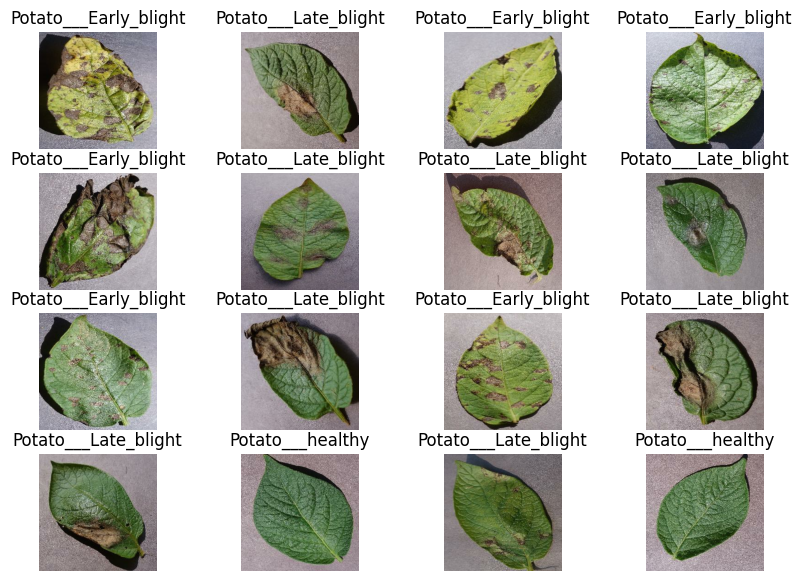

In [68]:
# visualizing data using matplotlib
plt.figure(figsize=(10,7))
for image,labels in dataset.take(1):
    print(image.shape,labels)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(classes[labels[i]])

In [16]:
# splitting data in train,val and test

In [34]:
len(dataset),len(dataset)*0.8,len(dataset)*0.2

(68, 54.400000000000006, 13.600000000000001)

In [40]:
ds_train=dataset.take(54)
ds_val=dataset.skip(54).take(7)

ds_test=dataset.skip(61)

In [41]:
len(ds_train) ,len(ds_val),len(ds_test),len(ds_test)+len(ds_val)+len(ds_train),len(dataset)

(54, 7, 7, 68, 68)

In [53]:
def train_val_test_split(dataset,train=0.8,test=0.1,val=0.1,shuffle=True):
    assert(train+test+val)==1
    ds_size=len(dataset)
    train_size=int(ds_size*train)
    val_size=int(ds_size*val)
    if shuffle:
        dataset.shuffle(5,seed=5)
    
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size+val_size)
    print(len(test_ds))
    
    return train_ds,val_ds,test_ds
    

    

In [54]:
train_ds,val_ds,test_ds=train_val_test_split(dataset)

8


In [49]:
# creating rescaling and resizing layers
image_rescale_resize=keras.models.Sequential()
image_rescale_resize.add(keras.layers.Resizing(256,256))
image_rescale_resize.add(keras.layers.Rescaling(1.0/255))

In [50]:
data_augmentation=keras.models.Sequential()
data_augmentation.add(keras.layers.RandomRotation(0.3))
data_augmentation.add(keras.layers.RandomFlip())

In [51]:
model=keras.Sequential()
model.add(image_rescale_resize)
model.add(data_augmentation)
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [56]:
model.build(input_shape=(256,256,3))

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [69]:
model.fit(train_ds,epochs=3,validation_data=val_ds,batch_size=32)

Epoch 1/3
54/54 [==============================] - 331s 6s/step - loss: 0.0986 - accuracy: 0.9647 - val_loss: 0.0909 - val_accuracy: 0.9531
Epoch 2/3
54/54 [==============================] - 321s 6s/step - loss: 0.0589 - accuracy: 0.9797 - val_loss: 0.1060 - val_accuracy: 0.9583
Epoch 3/3
54/54 [==============================] - 270s 5s/step - loss: 0.0609 - accuracy: 0.9780 - val_loss: 0.1495 - val_accuracy: 0.9323


In [63]:
train_ds=train_ds.cache()
val_ds=val_ds.cache()

In [70]:
model.evaluate(test_ds)

8/8 [==============================] - 49s 1s/step - loss: 0.2266 - accuracy: 0.9009


[0.22661808133125305, 0.9008620977401733]

#### previously saved model worked well on test dataset

In [66]:
model.save('potato_model.h5')

In [71]:
model1=keras.models.load_model('potato_model.h5')

In [72]:
tf.__version__

'2.10.1'

In [73]:
# testing images from the test dataset

actual label= Potato___Late_blight
1/1 [==============================] - 0s 65ms/step
predicted_label= Potato___Late_blight


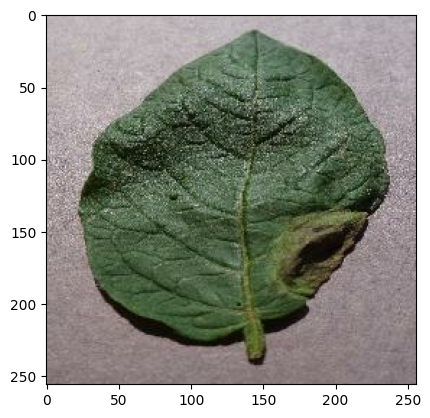

In [85]:
for images,labels in test_ds.take(1):
    test_img=images[0].numpy().astype('uint8')
    plt.imshow(test_img)
    print('actual label=',classes[labels[0].numpy()])
    y_p=model1.predict(np.expand_dims(test_img,0))
    print("predicted_label=",classes[np.argmax(y_p[0])])

In [98]:
# now we will create a generalized function
def predict(model,image_path):
#     this line of code will load and image from directory and convert it to array
    img=keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(image_path))
    y_p=model.predict(np.expand_dims(img,0))
    label=classes[np.argmax(y_p[0])]
    print(label)
    confidence=np.round(np.max(y_p[0])*100,2)
    print(confidence)
    return label,confidence

1/1 [==============================] - 0s 201ms/step
Potato___healthy


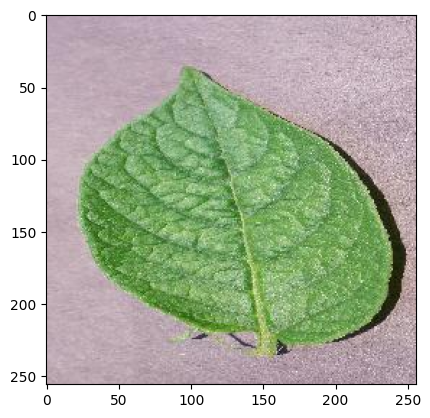

In [92]:
img=keras.preprocessing.image.load_img('test1.jpg')
img_array=keras.preprocessing.image.img_to_array(img)
plt.imshow(img_array.astype('uint8'))
label=classes[np.argmax(model.predict(np.expand_dims(img_array,0))[0])]
# print(img_array)
print(label)


1/1 [==============================] - 0s 283ms/step
Potato___Early_blight


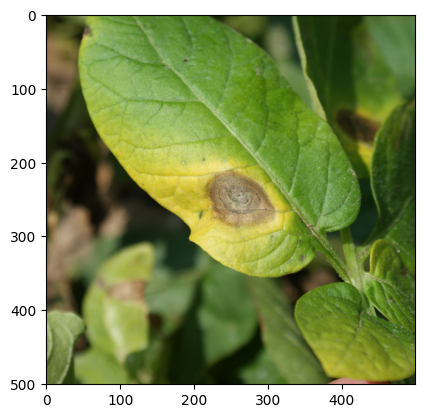

In [95]:
img=keras.preprocessing.image.load_img('test3.png')
img_array=keras.preprocessing.image.img_to_array(img)
plt.imshow(img_array.astype('uint8'))
label=classes[np.argmax(model.predict(np.expand_dims(img_array,0))[0])]
# print(img_array)
print(label)


In [102]:
predict(model1,'test3.png')

1/1 [==============================] - 0s 149ms/step
Potato___Early_blight
99.96


('Potato___Early_blight', 99.96)

In [106]:
predict(model1,'test6.jpg')

1/1 [==============================] - 0s 70ms/step
Potato___Early_blight
99.98


('Potato___Early_blight', 99.98)

In [112]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#instantiate the ImageDataGenerator class
datagen = ImageDataGenerator(
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#loop over the data in batches and this automatically saves the images
i = 0
for batch in datagen.flow_from_directory('tobeaugment/', batch_size=6,target_size=(256,256),
                          save_to_dir='augment/', save_format='jpg'):
    pass

Found 152 images belonging to 1 classes.


KeyboardInterrupt: 

In [113]:
# as we could see we didnt had much images of healthy potato plant leaf we didnt get proper predictions when we dowloaded images from google and 
# tested on our model
# now we will start phase 2 where we will rebuild another model with another architecture

In [114]:
dataset=keras.preprocessing.image_dataset_from_directory(
    'data',
    shuffle=True,
    image_size=(256,256),
    batch_size=32
    )


Found 3148 files belonging to 3 classes.


In [115]:
train_ds,val_ds,test_ds=train_val_test_split(dataset)

11


In [117]:
len(dataset)*32

3168

In [118]:
image_rescale_resize=keras.models.Sequential()
image_rescale_resize.add(keras.layers.Resizing(256,256))
image_rescale_resize.add(keras.layers.Rescaling(1.0/255))
data_augmentation=keras.models.Sequential()
data_augmentation.add(keras.layers.RandomRotation(0.3))
data_augmentation.add(keras.layers.RandomFlip())

In [120]:
model2=keras.Sequential()
model2.add(image_rescale_resize)
model2.add(data_augmentation)
model2.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(256,256,3)))
model2.add(keras.layers.MaxPool2D())
model2.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model2.add(keras.layers.MaxPool2D())
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(64,activation='relu'))
model2.add(keras.layers.Dense(3,activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [123]:
train_ds=train_ds.cache()

In [124]:
model2.fit(train_ds,validation_data=val_ds,epochs=5,batch_size=32)

Epoch 1/5
79/79 [==============================] - 440s 6s/step - loss: 1.1414 - accuracy: 0.6325 - val_loss: 0.3791 - val_accuracy: 0.8646
Epoch 2/5
79/79 [==============================] - 392s 5s/step - loss: 0.3233 - accuracy: 0.8699 - val_loss: 0.2819 - val_accuracy: 0.8993
Epoch 3/5
79/79 [==============================] - 412s 5s/step - loss: 0.2226 - accuracy: 0.9185 - val_loss: 0.3280 - val_accuracy: 0.9028
Epoch 4/5
79/79 [==============================] - 368s 5s/step - loss: 0.2235 - accuracy: 0.9205 - val_loss: 0.1973 - val_accuracy: 0.9201
Epoch 5/5
79/79 [==============================] - 381s 5s/step - loss: 0.1787 - accuracy: 0.9383 - val_loss: 0.2308 - val_accuracy: 0.9132


In [127]:
model2.fit(train_ds,validation_data=val_ds,epochs=10,batch_size=32)

Epoch 1/10
79/79 [==============================] - 278s 4s/step - loss: 0.1263 - accuracy: 0.9506 - val_loss: 0.3693 - val_accuracy: 0.9028
Epoch 2/10
79/79 [==============================] - 387s 5s/step - loss: 0.1045 - accuracy: 0.9612 - val_loss: 0.1583 - val_accuracy: 0.9410
Epoch 3/10
79/79 [==============================] - 320s 4s/step - loss: 0.0834 - accuracy: 0.9691 - val_loss: 0.3969 - val_accuracy: 0.9097
Epoch 4/10
79/79 [==============================] - 286s 4s/step - loss: 0.1166 - accuracy: 0.9585 - val_loss: 0.1256 - val_accuracy: 0.9653
Epoch 5/10
79/79 [==============================] - 370s 5s/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 0.2043 - val_accuracy: 0.9201
Epoch 6/10
79/79 [==============================] - 315s 4s/step - loss: 0.1294 - accuracy: 0.9557 - val_loss: 0.2258 - val_accuracy: 0.9201
Epoch 7/10
79/79 [==============================] - 322s 4s/step - loss: 0.0807 - accuracy: 0.9699 - val_loss: 0.1068 - val_accuracy: 0.9514
Epoch 8/10
79

In [129]:
model2.evaluate(test_ds)

11/11 [==============================] - 11s 694ms/step - loss: 0.1652 - accuracy: 0.9428


[0.1652473509311676, 0.9427710771560669]

In [137]:
predict(model2,'test2.jpg')

1/1 [==============================] - 0s 56ms/step
Potato___Early_blight
100.0


('Potato___Early_blight', 100.0)

In [136]:
model2.save('model2.h5')